# Seleccion de modelo y entranamiento de clasificador 

## Importar Librerias necesarias

In [14]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from PIL import Image
from SRC.modelo_clasificacion_crt import CustomClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

## Variables de entorno

In [ ]:


carpeta_preprocesadas = 'data/preprocesadas/'
train_normal =carpeta_preprocesadas+'train/NORMAL/'
train_pneumonia =carpeta_preprocesadas+'train/PNEUMONIA/'
test_normal =carpeta_preprocesadas+'test/NORMAL/'
test_pneumonia =carpeta_preprocesadas+'test/PNEUMONIA/'
val_normal =carpeta_preprocesadas+'val/NORMAL/'
val_pneumonia =carpeta_preprocesadas+'val/PNEUMONIA/'
dir_train =carpeta_preprocesadas+'train/'
dir_test =carpeta_preprocesadas+'test/'
dir_val =carpeta_preprocesadas+'val/'
salida_caracteristicas = 'data/caracteristicas/restnet50/'
caracteristicas_train = salida_caracteristicas + 'X_train_features.npy'
etiquetas_train = salida_caracteristicas + 'y_train_labels.npy'
caracteristicas_test = salida_caracteristicas + 'X_test_features.npy'
etiquetas_test = salida_caracteristicas + 'y_test_labels.npy'
caracteristicas_val = salida_caracteristicas + 'X_val_features.npy'
etiquetas_val = salida_caracteristicas + 'y_val_labels.npy'

## inicializar el modelo

In [16]:
# 1. Inicializar la clase (usa 2048 como input_shape)
classifier_manager = CustomClassifier(input_shape=2048)

# 2. Compilar el modelo con las métricas deseadas
classifier_manager.compile_model(learning_rate=0.001)

I0000 00:00:1763951438.001204   92396 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9162 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Estructura del modelo

In [17]:
classifier_manager.show_architecture()

--- Resumen del Modelo Clasificador Personalizado ---


Model: "RX_Custom_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114,881 (4.25 MB)

 Trainable params: 1,114,881 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

## cargar caracteristicas extraidas y etiquetas

In [18]:
x_train_features = np.load(caracteristicas_train)
y_train_labels = np.load(etiquetas_train)
x_test_features = np.load(caracteristicas_test)
y_test_labels = np.load(etiquetas_test)
x_val_features = np.load(caracteristicas_val)
y_val_labels = np.load(etiquetas_val)

## ponderacion de clases

In [19]:
from sklearn.utils import class_weight
import numpy as np 

# --- ASUMIENDO que y_train_labels ya ha sido cargado:
# y_train_labels = np.load(etiquetas_train)
print(f"Número de etiquetas cargadas: {len(y_train_labels)}")

# 1. Cálculo de los Pesos de Clase
# Se calcula el peso inversamente proporcional a la frecuencia de cada clase.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels), # Obtiene [0, 1]
    y=y_train_labels
)

# 2. Conversión al formato de Diccionario (requerido por Keras)
# Resultado: {0: peso_normal, 1: peso_anormal}
class_weights_dict = dict(enumerate(class_weights))

print("\n--- Resultados de Ponderación ---")
print(f"Array de pesos: {class_weights}")
print(f"Diccionario de pesos (class_weights_dict): {class_weights_dict}")
print("---------------------------------")

Número de etiquetas cargadas: 5216

--- Resultados de Ponderación ---
Array de pesos: [1.9448173  0.67303226]
Diccionario de pesos (class_weights_dict): {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
---------------------------------


## entrenamiento de modelo

In [20]:

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitorea la pérdida de validación
    patience=10,            # Paciencia de 5 épocas
    restore_best_weights=True  # Restaura los mejores pesos al finalizar
)

history = classifier_manager.model.fit(
    x_train_features, y_train_labels,
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict, 
    validation_data=(x_val_features, y_val_labels),
    callbacks=[early_stopping_callback],
    verbose=1
)

Epoch 1/150


2025-11-24 02:33:16.523955: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4a1c00c4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 02:33:16.524626: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-24 02:33:16.845699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 02:33:17.515363: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-24 02:33:17.896577: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 02:33:17.896673: I e

 24/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7006 - auc: 0.7916 - loss: 0.5647 - precision: 0.8810 - recall: 0.7021  

I0000 00:00:1763951605.541884   92556 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9028 - auc: 0.9654 - loss: 0.2405 - precision: 0.9670 - recall: 0.8999 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1238 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9473 - auc: 0.9885 - loss: 0.1317 - precision: 0.9839 - recall: 0.9445 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.0791 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9502 - auc: 0.9908 - loss: 0.1197 - precision: 0.9850 - recall: 0.9474 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1208 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9565 - auc: 0.9925 - loss: 0.1045 - precision: 0.9882 - recall: 0.9528 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0629 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━

In [21]:

# 1. Obtener las probabilidades (0 a 1)
y_pred_proba = classifier_manager.model.predict(x_test_features)

# 2. Convertir las probabilidades a clases binarias (0 o 1)
# Usamos el umbral estándar de 0.5. (Puedes ajustar este umbral si es necesario)
y_pred = (y_pred_proba > 0.5).astype(int) 

# Las etiquetas de clase (para el gráfico)
class_names = ['Normal (0)', 'Anormal (1)']

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 


Matriz de Confusión calculada:
 [[171  63]
 [  5 385]]


<Figure size 800x800 with 0 Axes>

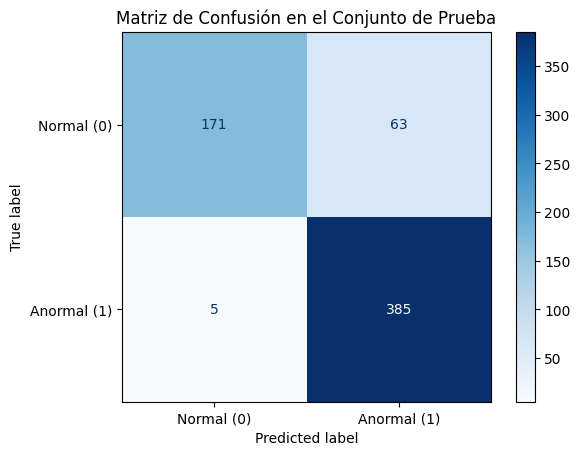

In [22]:
# 3. Calcular la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

print("Matriz de Confusión calculada:\n", cm)


# 4. Visualizar la matriz
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()

## SVM

In [23]:
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(x_train_features, y_train_labels)
y_svm_pred = svm_classifier.predict(x_test_features)


### metricas y matriz de confusion

In [24]:
## metricas

print("Reporte de Clasificación para SVM:\n")
class_names = ['Normal (0)', 'Anormal (1)']
print(classification_report(y_test_labels, y_svm_pred, target_names=class_names))


Reporte de Clasificación para SVM:

              precision    recall  f1-score   support

  Normal (0)       0.97      0.46      0.63       234
 Anormal (1)       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624



Matriz de Confusión calculada para SVM:
 [[108 126]
 [  3 387]]


<Figure size 800x800 with 0 Axes>

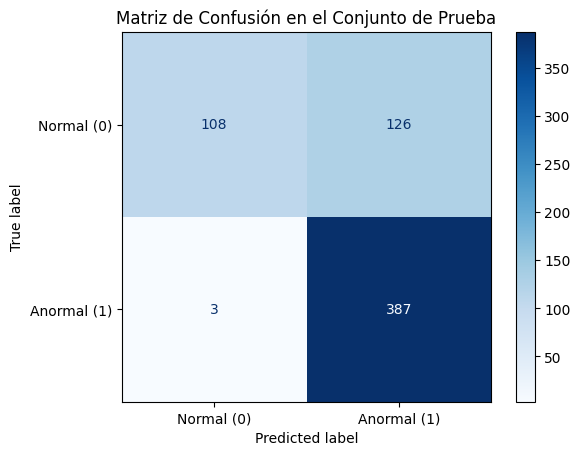

In [25]:
cm = confusion_matrix(y_test_labels, y_svm_pred)

print("Matriz de Confusión calculada para SVM:\n", cm)


# 4. Visualizar la matriz
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()

## knn

Reporte de Clasificación para KNN:

              precision    recall  f1-score   support

  Normal (0)       0.97      0.54      0.69       234
 Anormal (1)       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.81       624



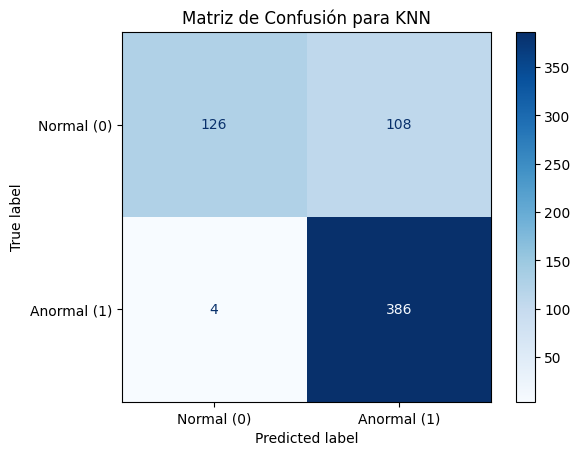

In [26]:
##knn con optimizacion de parametro k
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_features, y_train_labels)
y_knn_pred = knn_classifier.predict(x_test_features)
## metricas
print("Reporte de Clasificación para KNN:\n")
class_names = ['Normal (0)', 'Anormal (1)']
print(classification_report(y_test_labels, y_knn_pred, target_names=class_names))
cm = confusion_matrix(y_test_labels, y_knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión para KNN")
plt.show()

## Random Forest

Reporte de Clasificación para Random Forest:

              precision    recall  f1-score   support

  Normal (0)       0.97      0.38      0.55       234
 Anormal (1)       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.76      0.73       624



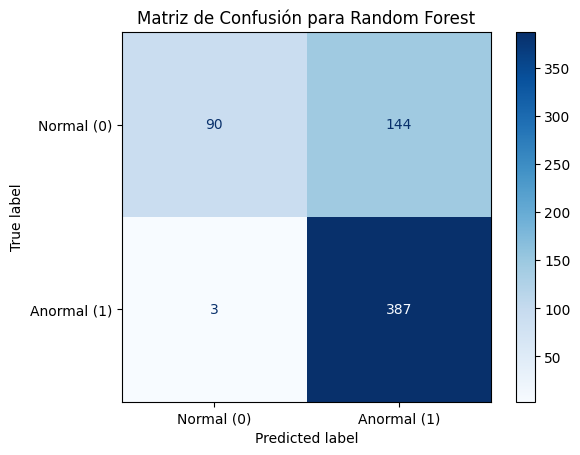

In [27]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_features, y_train_labels)
y_rf_pred = rf_classifier.predict(x_test_features)
## metricas
print("Reporte de Clasificación para Random Forest:\n")
class_names = ['Normal (0)', 'Anormal (1)']
print(classification_report(y_test_labels, y_rf_pred, target_names=class_names))
cm = confusion_matrix(y_test_labels, y_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión para Random Forest")
plt.show()